#  Optimizing Smart Grid Energy Distribution using GA and Parallel Computing


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time

##  Parameters and Simulated Data

In [2]:
NUM_ZONES = 10
NUM_SOURCES = 3
POP_SIZE = 50
GENERATIONS = 50
TOURNAMENT_SIZE = 3
MUTATION_RATE = 0.1

np.random.seed(42)
source_names = ["Solar", "Wind", "Hydro"]
zone_names = [f"Zone{i+1}" for i in range(NUM_ZONES)]
demand = np.random.randint(40, 80, size=NUM_ZONES)
capacities = np.array([200, 150, 250])
cost_matrix = np.array([
    np.random.randint(2, 5, NUM_ZONES),
    np.random.randint(3, 6, NUM_ZONES),
    np.random.randint(1, 4, NUM_ZONES)
])
loss_matrix = np.random.uniform(0.05, 0.2, size=(NUM_SOURCES, NUM_ZONES))
peak_penalty_zones = [1, 4, 7]

#  GA Components: Chromosome, Fitness, Selection, Crossover, Mutation

In [3]:
def create_chromosome():
    return np.random.uniform(0, 50, size=(NUM_SOURCES, NUM_ZONES))

def fitness(chrom):
    total_cost = np.sum(chrom * cost_matrix)
    total_loss = np.sum(chrom * loss_matrix)
    zone_supply = np.sum(chrom, axis=0)
    unmet = np.maximum(0, demand - zone_supply)
    penalty_unmet = np.sum(unmet**2)
    source_use = np.sum(chrom, axis=1)
    overused = np.maximum(0, source_use - capacities)
    penalty_overuse = np.sum(overused**2)
    peak_penalty = sum((demand[i] - zone_supply[i])**2 for i in peak_penalty_zones)
    return total_cost + 15 * total_loss + 40 * penalty_unmet + 30 * penalty_overuse + 50 * peak_penalty

In [4]:
def evaluate_population(population):
    with Pool() as pool:
        return pool.map(fitness, population)

In [5]:
def tournament_selection(pop, scores):
    selected = []
    for _ in range(len(pop)):
        group = random.sample(list(zip(pop, scores)), TOURNAMENT_SIZE)
        winner = min(group, key=lambda x: x[1])
        selected.append(winner[0])
    return selected

def crossover(p1, p2):
    alpha = np.random.uniform(0, 1, size=p1.shape)
    return alpha * p1 + (1 - alpha) * p2

def mutate(chrom):
    for i in range(NUM_SOURCES):
        for j in range(NUM_ZONES):
            if random.random() < MUTATION_RATE:
                chrom[i][j] += np.random.normal(0, 5)
                chrom[i][j] = max(0, chrom[i][j])
    return chrom

##  Run the Genetic Algorithm

In [6]:
def run_ga():
    population = [create_chromosome() for _ in range(POP_SIZE)]
    best_scores = []
    for gen in range(GENERATIONS):
        scores = evaluate_population(population)
        best_scores.append(min(scores))
        selected = tournament_selection(population, scores)
        next_gen = []
        for i in range(0, POP_SIZE, 2):
            p1, p2 = selected[i], selected[(i + 1) % POP_SIZE]
            c1, c2 = crossover(p1, p2), crossover(p2, p1)
            next_gen += [mutate(c1), mutate(c2)]
        population = next_gen
    return population, best_scores

##  Execute and Visualize Results

In [7]:
start = time.time()
final_pop, best_fitness_scores = run_ga()
end = time.time()
print(f"✅ Final Best Fitness: {best_fitness_scores[-1]:.2f}")
print(f"⏱️ Total Runtime: {end - start:.2f} seconds")

✅ Final Best Fitness: 3579.55
⏱️ Total Runtime: 1.59 seconds


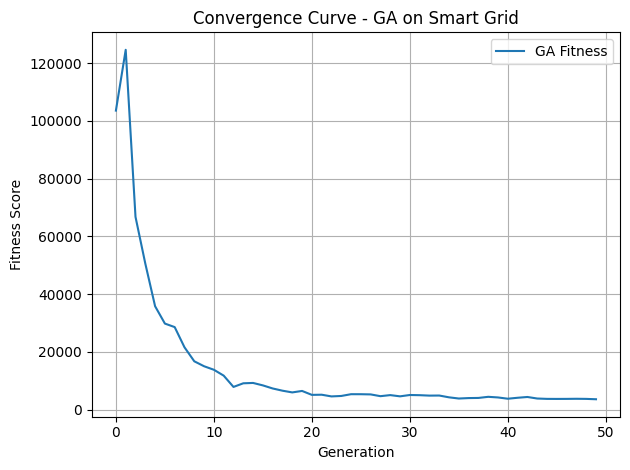

In [8]:
plt.plot(best_fitness_scores, label='GA Fitness')
plt.title("Convergence Curve - GA on Smart Grid")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()